In [2]:
using Agents
using DynamicalSystems
using InteractiveDynamics
using CairoMakie
using Plots
using StatsPlots

using Random
using Distributions
using Colors
using ColorSchemes
using Measures
using StatsBase
using PyCall
using Statistics
using KernelDensity
using Loess
using QuadGK
using ForwardDiff

In [3]:
seed = 123

123

In [4]:
const NN = 30
const GRID_DIM = (NN,NN)
TOTAL_AGENTS = round( Int, 0.25*prod(GRID_DIM) );

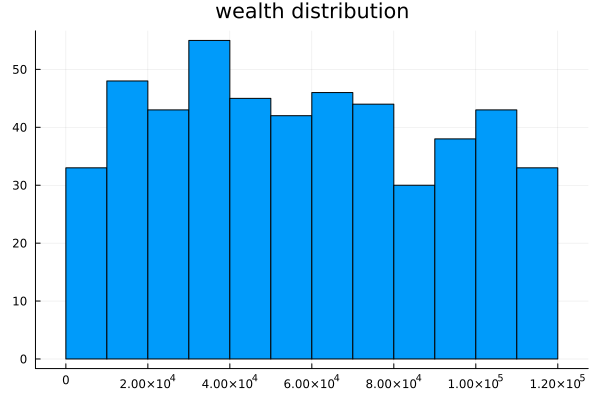

In [7]:
function Mix(x, d1,d2) 
    return pdf(d1, x) + pdf(d2,x)
end

MEAN_MONEY = 60_000
SD_MONEY = 5_000;
SHAPE_PARAMETER_XI = 0.5
MONEY_DISTRIBUTION = Uniform( 1, 2*MEAN_MONEY ) # GeneralizedPareto(MEAN_MONEY, SD_MONEY, SHAPE_PARAMETER_XI) 

d1 = GeneralizedPareto(MEAN_MONEY, SD_MONEY, SHAPE_PARAMETER_XI) 
d2 = Gamma(MEAN_MONEY,0.5)

#println(Mix(60_000,d1,d2))

data = [ rand(MONEY_DISTRIBUTION,1)[1] for _ in 1:500 ]
Plots.histogram( data, bins=12, title="wealth distribution", legend=false )

In [8]:
AGENTS_MONEY = rand(MONEY_DISTRIBUTION, TOTAL_AGENTS)
MAX_MONEY = maximum( AGENTS_MONEY );
MOVEMENT_ENERGY_MIN_REQUIREMENT = 0.2

KineticEnergy(money) = 2 * money / MAX_MONEY

InvKineticEnergy(kinetic_energy) = (1/2) * MAX_MONEY * kinetic_energy #returns the money and money is then effectively the energy

PotentialEnergy(remain) = 1 * Int( !remain )

PotentialEnergy (generic function with 1 method)

In [9]:
FIXED_ENERGY_BINS = 0:0.2:1_000;

In [11]:
model_iteration = 0;

In [12]:
@agent SchellingAgent GridAgent{2} begin
    remain::Bool # whether the agent is happy to remain in its position. (true = remain, false = !remain)
    group::Int # The group of the agent, determines remain as it interacts with neighbors
    money::Float64 # how much money the agent has
    
    potential_energy::Int #identity
    kinetic_energy::Float64 #money as it is dissipated
    
end

In [14]:
function initialize()
    
    global model_iteration = 0
    
    space = GridSpaceSingle( GRID_DIM , periodic = true ) #, metric = :manhattan )
    
    properties = Dict( :neighborhood_radius => 4, :ratio_agree_happy => 0.8 )
    rng = Random.Xoshiro(seed)
    
    model = UnremovableABM(SchellingAgent, space; properties, 
                            rng=Random.Xoshiro(seed), scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    
    for ii in 1:TOTAL_AGENTS
        remain_i = false
        identity_i = ii < TOTAL_AGENTS/2 ? 1 : 2
        money_i = AGENTS_MONEY[ii]
        
        potential_energy_i = PotentialEnergy(remain_i)
        kinetic_energy_i = KineticEnergy(money_i)
        
        agent = SchellingAgent(ii, (1, 1), remain_i, identity_i, money_i,
                                    potential_energy_i, kinetic_energy_i)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [15]:
function GetAgentRemainStatus(agent, model)
    
    #agent moves it remain is false and kinetic is higher than potential
    kinetic_higher_than_potential = agent.kinetic_energy > MOVEMENT_ENERGY_MIN_REQUIREMENT #PotentialEnergy(agent.remain)

    remain = true

    neighbors = nearby_agents( agent, model, model.neighborhood_radius )

    similar = 0
    for neighbor in neighbors
         if( neighbor.group == agent.group )
            similar += 1
        end        
    end 
    
    if ( similar/length(collect(neighbors)) ) >= model.ratio_agree_happy
        remain = true
    else
        remain = false
    end
    
    if( kinetic_higher_than_potential == true && remain == false )
        return false
    else
        return true
    end    
        
end

GetAgentRemainStatus (generic function with 1 method)

In [16]:
function GetAgentHappiness(agent, model)
    
    #agent moves it remain is false and kinetic is higher than potential

    neighbors = nearby_agents( agent, model, model.neighborhood_radius )

    similar = 0
    for neighbor in neighbors
         if( neighbor.group == agent.group )
            similar += 1
        end        
    end 
    
    if ( similar/length(collect(neighbors)) ) >= model.ratio_agree_happy
        happy = true
    else
        happy = false
    end
    
        
end

GetAgentHappiness (generic function with 1 method)

In [17]:
function MovementMoneySpending(agent, model)
    
    money_spent = InvKineticEnergy(MOVEMENT_ENERGY_MIN_REQUIREMENT)
    
    if( money_spent >= agent.money )
        return
    else
        agent.money -=  money_spent
    end
    
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
    number_of_neighbors = length( collect( nearby_agents( agent, model, model.neighborhood_radius ) ) )
    neighbor_dividend = money_spent / number_of_neighbors
    # modify to have only 1 agent receive all the quanta of money
    for neighbor in nearby_agents( agent, model, model.neighborhood_radius )
        neighbor.money += neighbor_dividend
        neighbor.kinetic_energy = KineticEnergy(neighbor.money)
    end
    
end

MovementMoneySpending (generic function with 1 method)

In [18]:
function MoneySpending(agent, model)
    money_spent = agent.money * 0.005
    
    agent.money -=  money_spent
    agent.kinetic_energy = KineticEnergy(agent.money)
    
end

MoneySpending (generic function with 1 method)

# movement dynamics

- if agent unhappy agent needs to leave the locality. 

In [19]:
isempty([])

true

In [20]:
function Get_NextPosition(agent,model)
    empty_positions_tmp = empty_nearby_positions( agent, model, model.neighborhood_radius )
    
    if( isempty(empty_positions_tmp) == true )
        return []
    end
    
    happy_positions = []
    for empty_position_tmp in empty_positions_tmp
       
        surrounding_ids_tmp = nearby_ids(empty_position_tmp, model, model.neighborhood_radius )
        surrounding_agents_tmp = [model[id] for id in surrounding_ids_tmp]
        
        similar = -1
        for surrounding_agent_tmp in surrounding_agents_tmp
            if( surrounding_agent_tmp.group == agent.group )
                similar += 1
            end            
        end
        
        if( (similar/(length(collect(surrounding_agents_tmp))-1)) >= model.ratio_agree_happy )
            push!(happy_positions,empty_position_tmp) 
        end        
        
    end
    
    if( isempty(happy_positions) == true )
        rand_ind = rand( 1:length(collect(empty_positions_tmp)) )
        return collect(empty_positions_tmp)[rand_ind]
    end
    
    rand_ind = rand( 1:length(collect(happy_positions)) )
    return collect(happy_positions)[rand_ind]
    
end

Get_NextPosition (generic function with 1 method)

In [22]:
function agent_step!(agent, model; move_regardless=false)
    
    
    agent.remain = GetAgentRemainStatus(agent, model) 
    agent.potential_energy = PotentialEnergy( agent.remain )
 
    
    if agent.remain == false || move_regardless
        
        #move to position which is the ** #move_agent_single!(agent, model)
        #empty_positions_tmp = empty_nearby_positions( agent, model, model.neighborhood_radius )
        
        new_position_tmp = Get_NextPosition(agent,model)
        
        if( isempty(new_position_tmp) == false )
            #rand_ind = rand( 1:length(collect(empty_positions_tmp)) )
            #empty_position = collect(empty_positions_tmp)[rand_ind]
    #         println("zol")
            move_agent!( agent, new_position_tmp, model )        

            #money held by agent changes
            MovementMoneySpending(agent, model)
        end
    end
    #money changes by agent time
    MoneySpending(agent, model)    
    
end

agent_step! (generic function with 1 method)

In [23]:
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

function ModelHappinessTrajectory(model)
    count = 0
    
    for agent in allagents(model)
        
        neighbors = nearby_agents( agent, model, model.neighborhood_radius )

        similar = 0
        for neighbor in neighbors
            if (neighbor.group == agent.group)
                similar += 1
            end        
        end 
        
        if ( similar/length(collect(neighbors)) ) >= model.ratio_agree_happy
            happy = true
        else
            happy = false
        end
        
        if (happy)
            count = count +1
        end
    end
     
    return count
end


function ModelFinancialDisparity(model)
    disparity = 0
    for agent in allagents(model)
        
        disparity_temp = 0
        number_of_neighbors = length( collect( nearby_agents(agent, model, model.neighborhood_radius ) ) )
        
        for neighbor in nearby_agents(agent, model, model.neighborhood_radius )
            disparity_temp += abs( agent.money - neighbor.money )
        end
        
        if( number_of_neighbors > 0 )
            disparity_temp = disparity_temp / number_of_neighbors
            disparity += disparity_temp
        end

    end
    return disparity
end

function ModelEntropy(model)
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy 
        push!(agent_energies, agent_energy)
    end
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)
    
    SS = 0
    for ii in 1:length( energy_probabilities )
        SS += (-1) * energy_probabilities[ii] * log( energy_probabilities[ii] )
    end
    
    return SS
end

function ModelInternalEnergy(model)
    # U = sum_distinct_states_i p_i * E_i
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy
        push!(agent_energies, agent_energy)
    end
    
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_probabilities = energy_hist.weights ./ sum(energy_hist.weights)
    energy_edges = collect( energy_hist.edges[1] )
    energy_values = [ (energy_edges[i]+energy_edges[i+1])/2 for i in 1:length(energy_edges)-1 ]
    
    UU = 0
    for ii in 1:length(energy_values)
        UU += energy_probabilities[ii] * energy_values[ii]
    end
    
    return UU
end


    

ModelInternalEnergy (generic function with 1 method)

In [24]:
function ModelEntropyShannon_Remain(model)
    
    agent_remains = Int[]
    
    for agent in allagents(model)
        agent_remain = agent.remain
        push!(agent_remains, agent_remain)
    end
    remain_probs = []
    for state_type in unique(Int.(agent_remains))
        percentage_state = length(findall( state_type .== agent_remains )) / length(agent_remains)
        push!(remain_probs,percentage_state)
    end
    remain_H = 0
    for prob in remain_probs
        remain_H = remain_H - prob * log(prob)
    end
    
    return remain_H
end

function ModelEntropyShannon_Money(model)
    
    agent_monies = Float64[]
    for agent in allagents(model)
        push!(agent_monies,agent.money)
    end      
    
    money_hist = fit(Histogram, agent_monies, 0:10_000:MAX_MONEY )
    money_weights = money_hist.weights    
    nonzero_weights = filter(!iszero, money_weights)
    money_probabilities = nonzero_weights ./ sum(nonzero_weights)
    
    money_H = 0
    for prob in money_probabilities
        money_H = money_H - prob * log(prob)
    end
        
    return money_H
end

ModelEntropyShannon_Money (generic function with 1 method)

In [26]:
agent_money_gain = 100_000

100000

In [27]:
function count_agents_and_positions_in_bounding_box(pos1, pos2, grid_size, model)
    x_min = min(pos1[1], pos2[1])
    x_max = max(pos1[1], pos2[1])
    y_min = min(pos1[2], pos2[2])
    y_max = max(pos1[2], pos2[2])
    
    # Check for periodicity and adjust corners if needed
    x_wrap = false
    y_wrap = false
    if x_max - x_min > grid_size[1] / 2
        x_min, x_max = x_max, x_min
        x_wrap = true
    end
    if y_max - y_min > grid_size[2] / 2
        y_min, y_max = y_max, y_min
        y_wrap = true
    end
    
    # Count positions in the bounding box
    position_count = 0
    for x in 1:grid_size[1]
        for y in 1:grid_size[2]
            in_box = (
                (x_wrap ? (x <= x_max || x >= x_min) : (x >= x_min && x <= x_max)) &&
                (y_wrap ? (y <= y_max || y >= y_min) : (y >= y_min && y <= y_max))
            )
            if in_box
                position_count += 1
            end
        end
    end
    
    # Check each agent's position and count those within the bounding box
    agent_count = 0
    for agent in allagents(model)
        x, y = agent.pos  # Assuming agent's position is stored in `pos` field
        in_box = (
            (x_wrap ? (x <= x_max || x >= x_min) : (x >= x_min && x <= x_max)) &&
            (y_wrap ? (y <= y_max || y >= y_min) : (y >= y_min && y <= y_max))
        )
        if in_box
            agent_count += 1
        end
    end
    
    return position_count, agent_count
end

# println( count_agents_and_positions_in_bounding_box( (2,2), (3,3), (30,30), model ) )
# println( count_agents_and_positions_in_bounding_box( (2,1), (4,29), (30,30), model ) )
# println( count_agents_and_positions_in_bounding_box( (2,2), (5,5), (30,30), model ) )

count_agents_and_positions_in_bounding_box (generic function with 1 method)

In [28]:

function Model_Speed_of_Sound(model)
    
    contact_distance = 1.65 #dist of (3,3) with (4,4) is 1.41
    sound_step_num_max = 150
    speeds_of_sounds = []
    densities = []
    sound_sample_num = 50
    
    for iter in 1:sound_sample_num
        model_copy = deepcopy(model) #copy of the model to experiment with

        for agent_copy in allagents(model_copy) #set the money for each agent to zero
            agent_copy.money = 0.0
        end

        # Choose a random pair of unique agents
        agents_copy_ids = collect(allids(model_copy))
        selected_copy_ids = rand(agents_copy_ids, 2) # Randomly select two ids without replacement
        agent1_copy = model_copy[selected_copy_ids[1]]
        agent2_copy = model_copy[selected_copy_ids[2]]
        agent1_copy.money = agent_money_gain
        distance_initial = euclidean_distance(agent1_copy, agent2_copy, model_copy)

        if( distance_initial <= contact_distance )
            #try another pair 
            continue
        end
        
        position_count, agent_count = count_agents_and_positions_in_bounding_box( agent1_copy.pos, agent2_copy.pos, GRID_DIM, model )
        density_tmp = Float64( round( agent_count / position_count, digits=5) )

        speed_of_sound_tmp = -1

        for step_num_tmp in 1:sound_step_num_max

            for agent_tmp in allagents(model_copy)
                if( agent_tmp === agent1_copy )
                    agent_step!(agent_tmp, model_copy; move_regardless=true)
                else
                    agent_step!(agent_tmp, model_copy)
                end
            end

            distance_tmp = euclidean_distance(agent1_copy, agent2_copy, model_copy)
            #remain_tmp = GetAgentRemainStatus(agent1_copy, model_copy) 
            #println("distance_tmp = $(distance_tmp), agent1_copy.pos = $(agent1_copy.pos)")        
            if( distance_tmp <= contact_distance )            
                speed_of_sound_tmp = Float64( round( distance_initial / step_num_tmp , digits=5) )
                push!( speeds_of_sounds, speed_of_sound_tmp)
                push!( densities, density_tmp)
                # println("contact! speed_of_sound= $speed_of_sound_tmp, step_num_tmp = $step_num_tmp")
                break
            end

        end
    end
    
    #println("speeds_of_sounds = $(speeds_of_sounds)")
    
    return [speeds_of_sounds,densities] # Int64(round( (10^4) * speed_of_sound_tmp ))
end


Model_Speed_of_Sound (generic function with 1 method)

In [29]:

function model_step!(model)
    global model_iteration += 1
    
    if( model_iteration % 200 == 0 && model_iteration != 0 )
        for agent in allagents(model)
            agent.money += agent_money_gain
            agent.kinetic_energy = KineticEnergy(agent.money)
        end        
    end
    
end

model_step! (generic function with 1 method)

In [30]:
model = initialize()

adata = [ :potential_energy, :kinetic_energy ]
mdata = [ ModelRemainTrajectory, ModelFinancialDisparity, 
                        ModelEntropy, ModelInternalEnergy,
                        ModelEntropyShannon_Remain, ModelEntropyShannon_Money,
                        Model_Speed_of_Sound,
                        ModelHappinessTrajectory]

step_num = 50
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata)

(11475×4 DataFrame
   Row │ step   id     potential_energy  kinetic_energy 
       │ Int64  Int64  Int64             Float64        
───────┼────────────────────────────────────────────────
     1 │     0      1                 1       0.577259
     2 │     0      2                 1       1.25716
     3 │     0      3                 1       0.647974
     4 │     0      4                 1       0.345747
     5 │     0      5                 1       0.427281
     6 │     0      6                 1       0.626834
     7 │     0      7                 1       0.424881
     8 │     0      8                 1       0.0472148
   ⋮   │   ⋮      ⋮           ⋮                ⋮
 11469 │    50    219                 0       0.523164
 11470 │    50    220                 0       0.848899
 11471 │    50    221                 0       0.695628
 11472 │    50    222                 0       1.17344
 11473 │    50    223                 0       0.135973
 11474 │    50    224                 0       1

In [31]:
res = model_df[!,:Model_Speed_of_Sound]
println(length(res[2][1]))
println(length(res[2][2]))

26
26


In [110]:
names(model_df)

9-element Vector{String}:
 "step"
 "ModelRemainTrajectory"
 "ModelFinancialDisparity"
 "ModelEntropy"
 "ModelInternalEnergy"
 "ModelEntropyShannon_Remain"
 "ModelEntropyShannon_Money"
 "Model_Speed_of_Sound"
 "ModelHappinessTrajectory"

In [115]:

model_df[:,:ModelEntropy]

51-element Vector{Float64}:
 2.311604740815786
 2.3635329184347564
 2.296538995701232
 2.3032066384002654
 2.2573257319140088
 2.229202047730368
 2.2477779313300488
 2.239539147618022
 2.248668690272568
 2.2299792251865087
 ⋮
 2.225289119292957
 2.220216795511336
 2.211475397389003
 2.213588840803092
 2.210686745279882
 2.204783609821125
 2.1984613216689217
 2.194289098233908
 2.1829740675436913

In [141]:
x_sorted

724-element Vector{Any}:
 0.04545
 0.06494
 0.1
 0.10119
 0.1125
 0.11364
 0.1157
 0.12121
 0.12698
 0.12857
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [137]:
y_agg = []
x_agg = []
for time in 1:length(res)
    y = Float64.(res[time][1])
    x = Float64.(res[time][2]);
    push!(x_agg,x...)
    push!(y_agg,y...)
end
p = sortperm(x_agg)
x_sorted = x_agg[p];

In [138]:
model = loess(x_agg, y_agg)
#yhat = predict(model, x_agg);
#yhat_sorted = yhat[p]

MethodError: MethodError: no method matching float(::Type{Any})

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

Closest candidates are:
  float(::Type{Union{Missing, T}}) where T at missing.jl:112
  float(::Any) at float.jl:269
  float(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}) at ~/.julia/packages/StatsBase/XgjIN/src/statmodels.jl:86
  ...

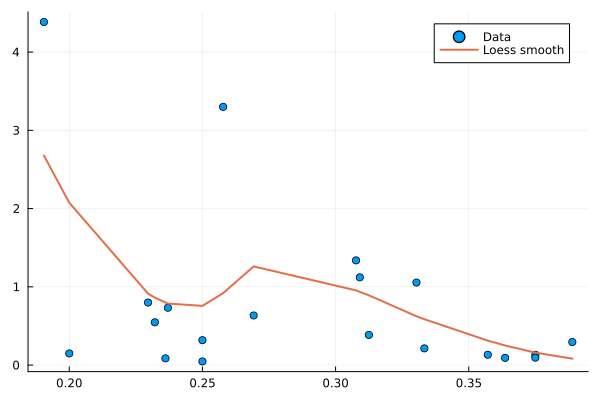

In [128]:
Plots.scatter(x, y, label="Data", size(500,200))
Plots.plot!(x_sorted, yhat_sorted, label="Loess smooth", linewidth=2,size(500,200))

In [36]:
function loess_curve(x_val)
    return predict(model, x_val)
end

loess_curve (generic function with 1 method)

In [37]:
predict(model, 0.3)

0.319086076041323

In [38]:
integral, _ = quadgk(loess_curve, x_sorted[1], x_sorted[end])
integral

0.05400661099282189

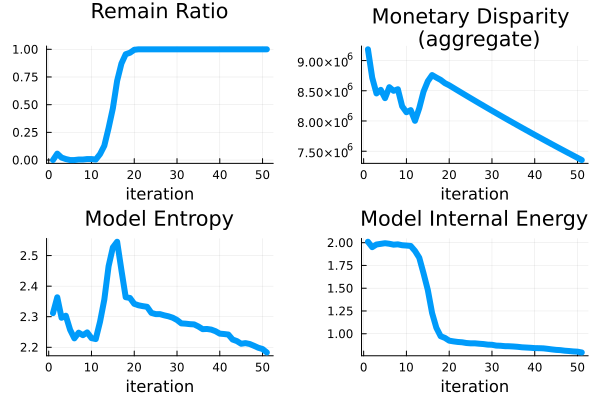

In [107]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
            title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )
p3 = Plots.plot( model_df[!,:ModelEntropy], linewidth=6, legend=false,
            title="Model Entropy", xlabel="iteration" )
p4 = Plots.plot( model_df[!,:ModelInternalEnergy], linewidth=6, legend=false,
            title="Model Internal Energy", xlabel="iteration" )
p5 = Plots.plot( model_df[!,:ModelHappinessTrajectory], linewidth=6, legend=false,
title="Model Happiness aggregate", xlabel="iteration" )

#savefig(p1,"./plots/pOverallApnt8.pdf")            
#savefig(p2,"./plots/pOverallBpnt8.pdf")            
#savefig(p3,"./plots/pOverallCpnt8.pdf")            
#savefig(p4,"./plots/pOverallDpnt8.pdf")            

pOveral = Plots.plot([p1,p2,p3,p4]..., layout=grid(2,2) )
#savefig(pOveral,"./plots/pOverallpnt8.pdf")
display(pOveral)

In [40]:
model_entropies = model_df[!,:ModelEntropy]

51-element Vector{Float64}:
 2.311604740815786
 2.3635329184347564
 2.296538995701232
 2.3032066384002654
 2.2573257319140088
 2.229202047730368
 2.2477779313300488
 2.239539147618022
 2.248668690272568
 2.2299792251865087
 ⋮
 2.225289119292957
 2.220216795511336
 2.211475397389003
 2.213588840803092
 2.210686745279882
 2.204783609821125
 2.1984613216689217
 2.194289098233908
 2.1829740675436913

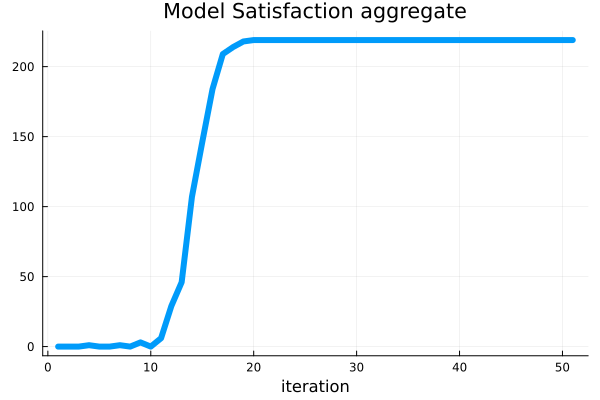

In [106]:

p5 = Plots.plot( model_df[!,:ModelHappinessTrajectory], linewidth=6, legend=false,
title="Model Satisfaction aggregate", xlabel="iteration" )

            

pOveral = Plots.plot([p5]..., layout=grid(1,1) )
#savefig(pOveral,"./plots/pSatisfactionpnt8.pdf")
display(pOveral)

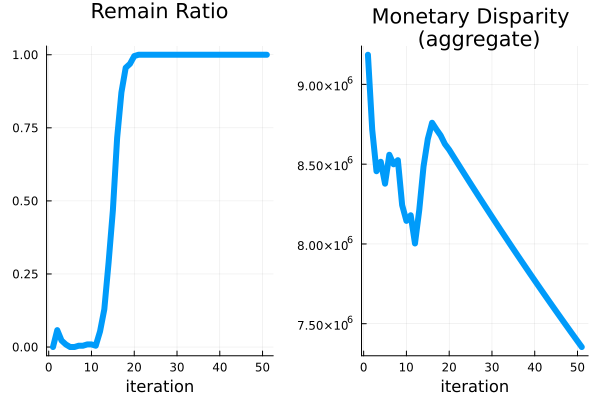

In [105]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
            title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )

pOveral = Plots.plot([p1,p2]..., layout=grid(1,2) )
#savefig(pOveral,"./plots/pRemainDisparitypnt8.pdf")
display(pOveral)

In [74]:
exp_fit = 0
lambda = 0
gamma_fit = 0

function pdf_exp_fit(x)
    
    pdf(exp_fit, x)
end

function Hist_Derivative(energy)
    return ForwardDiff.derivative( pdf_exp_fit , energy )
    #return f_prime
end

function Height_FN(energy)
    Hist_Derivative(energy) * log( pdf_exp_fit(energy) )
    #f_prime(energy) * log( pdf_exp_fit(energy) ) 
end

Height_FN (generic function with 1 method)

In [75]:
function f_prime(x)
    
    return -(lambda^2) * exp(-lambda * x)
    
end

f_prime (generic function with 1 method)

In [76]:
Tenergies = []

for STEP_NUM in 1:maximum( agent_df.step )
    step_tmp = filter(row -> row.step == STEP_NUM, agent_df);

    energies = []
    for row in eachrow( step_tmp )
        energy_tmp = row.potential_energy + row.kinetic_energy
        push!(energies,energy_tmp)
    end

    m_low = minimum(energies)
    m_high = maximum(energies)
    step_size = (m_high - m_low) / length(energies)
    energy_bins = m_low:step_size:m_high

    energy_hist = fit(Histogram, energies, energy_bins)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)

    #global gamma_fit = fit(Gamma, energy_probabilities)
    global exp_fit = fit(Exponential, energy_probabilities)
    global lambda = exp_fit.θ

    integral_value, error_estimate = quadgk( Height_FN , m_low, m_high )

    T = (1/integral_value) #1.38*10^-23 * (1/integral_value)

    push!(Tenergies,T)
end

Tenergies

50-element Vector{Any}:
   4.8571568869934e8
   1.0121410029144689e9
   1.2726854650240922e20
   4.272046538267657e64
   2.6435476843275802e66
   6.387606723277398e9
   1.604228758938223e14
   1.5836070041439479e13
   1.5301900984704675e11
   1.0502493057497106e16
   ⋮
 -25.154780507799373
 -10.46480597130278
  -6.524991576593313
  -4.697447882541746
  -3.643457337468429
  -2.9582443321609193
  -2.4774842617257624
  -2.1218454125937165
  -1.8483305324476662

In [98]:
using DataFrames  
using StatsBase  
using Loess     
using Plots

Tenergies = []

for STEP_NUM in 1:maximum(agent_df.step)
    step_tmp = filter(row -> row.step == STEP_NUM, agent_df)

    energies = []
    for row in eachrow(step_tmp)
        energy_tmp = row.potential_energy + row.kinetic_energy
        push!(energies, energy_tmp)
    end

    m_low = minimum(energies)
    m_high = maximum(energies)
    step_size = (m_high - m_low) / length(energies)
    energy_bins = m_low:step_size:m_high

    energy_hist = fit(Histogram, energies, energy_bins)
    bin_centers = [(energy_bins[i] + energy_bins[i+1]) / 2 for i in 1:length(energy_bins)-1]
    energy_weights = energy_hist.weights

    # Apply LOESS smoothing
    loess_model = loess(bin_centers, energy_weights)
    smoothed_values = predict(loess_model, bin_centers)

    # Plotting the histogram and LOESS curve
    #p = Plots.histogram(energies, bins=energy_bins, title="Energy Distribution at Step $STEP_NUM", xlabel="Energy", ylabel="Count")
    #Plots.plot!(p, bin_centers, smoothed_values, linewidth=2, color=:red)  # Overlay the LOESS curve
    #Plots.display(p)

    integral_value, error_estimate = quadgk( Height_FN , m_low, m_high )

    T = (1/integral_value) #1.38*10^-23 * (1/integral_value)

    push!(Tenergies,T)

end

Tenergies


50-element Vector{Any}:
   9.152734966513077e9
   3.3909720727495552e10
   8.265654253301006e22
   4.5500328939366195e63
   1.3914004839874157e62
   5.003268196750898e12
   1.8193394348308102e17
   8.101135276428529e15
   4.780197689558756e13
   9.932995099992066e19
   ⋮
 -25.154780507799373
 -10.46480597130278
  -6.524991576593313
  -4.697447882541746
  -3.643457337468429
  -2.9582443321609193
  -2.4774842617257624
  -2.1218454125937165
  -1.8483305324476662

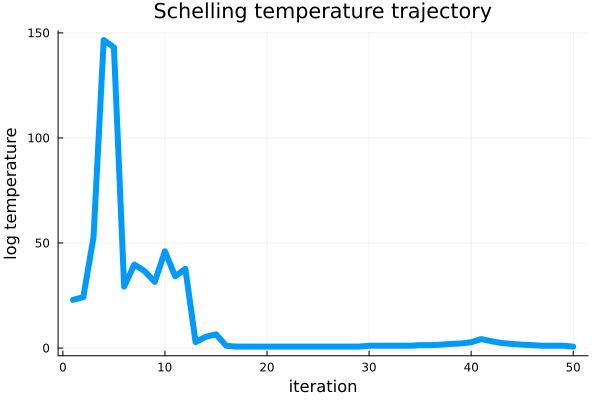

In [99]:
pTemp = Plots.plot(  log.(ceil.(abs.(Tenergies))),
                     linewidth=6, 
             xlabel="iteration" ,
                    title="Schelling temperature trajectory", ylab="log temperature", legend=false)
#savefig(pTemp,"./plots/pTemppnt8.pdf")
display(pTemp)

In [100]:
# G(p,T)= H-TS = U+pV-TS

In [101]:
function Pressure(curve, xmin, xmax )
    
    return quadgk(curve, xmin, xmax)
end

Pressure (generic function with 1 method)

In [102]:
function loess_curveSQ(x_val)
    return predict(model, x_val)^2
end

loess_curveSQ (generic function with 1 method)

In [103]:
pressures = []

for iteration in 1:step_num
    y = Float64.(res[iteration][1])
    x = Float64.(res[iteration][2]);
    p = sortperm(x)
    x_sorted = x[p]
    
    model = loess(x, y)
    yhat = predict(model, x);
    yhat_sorted = yhat[p];
    integral, _ = Pressure(loess_curveSQ, x_sorted[1], x_sorted[end])
    pressure = integral
    push!(pressures,pressure)    
end

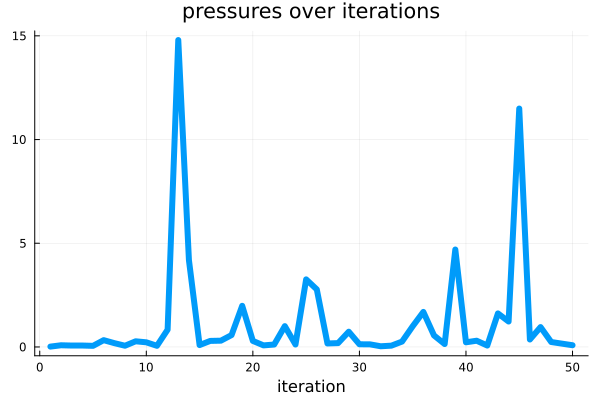

In [104]:
pressures = Plots.plot(pressures, title="pressures over iterations",  linewidth=6, 
             xlabel="iteration", legend=false )
#savefig(pressures,"./plots/pressurespnt8.pdf")
display(pressures)

In [81]:
model_entropies = model_df[!,:ModelEntropy]


51-element Vector{Float64}:
 2.311604740815786
 2.3635329184347564
 2.296538995701232
 2.3032066384002654
 2.2573257319140088
 2.229202047730368
 2.2477779313300488
 2.239539147618022
 2.248668690272568
 2.2299792251865087
 ⋮
 2.225289119292957
 2.220216795511336
 2.211475397389003
 2.213588840803092
 2.210686745279882
 2.204783609821125
 2.1984613216689217
 2.194289098233908
 2.1829740675436913

In [82]:
function Heat(i)
    return  log.(ceil.(abs.(Tenergies)))[i] * (model_entropies[i]-model_entropies[i-1])

end

Heat (generic function with 1 method)

In [108]:
# P = rho^2 dA(rho,T)/drho
# for 1 time point 
function Helmholtz(rho,T)
    #we have 2 arrays, temperatures (Tenegies) and densities - 1D arrays, with one value per timestep
    #we have the entropy and the internal energy - 1D arrays, with one value per timestep
    #per timestep we have all the 4 variables
    #Helmholtz[i]=U[i]-T[i]*S[i]
    densities = model_df[:,:Model_Speed_of_Sound][iteration][2]
    density = 
    entropy = model_df[:,:ModelEntropy][iteration]
    
end

Helmholtz (generic function with 1 method)

In [83]:
heats = []

for i in 2:step_num
    heat = abs.(Heat(i))
    push!(heats,heat)    
end

In [84]:
pHeat = Plots.plot( heats, linewidth=6, xlabel="iteration" ,
                    title="Heat Trajectory", ylab="Heat", legend=false)

savefig(pHeat,"./plots/pHeatpnt8.pdf")
display(pHeat)

SystemError: SystemError: opening file "/Users/rafaeldomenikos/Desktop/My_Files/AI intro/plots/pHeatpnt8.pdf": No such file or directory

In [85]:
x = 0:0.01:0.15
y1 = pdf.(gamma_fit,x)
y2 = pdf.(exp_fit,x)
p1 = histogram(energy_probabilities, normed=true)
Plots.plot!(x,y1,linewidth=5, title="gamma")
p2 = histogram(energy_probabilities, normed=true)
Plots.plot!(x,y2,linewidth=5, title="exponential")
Plots.plot(p1,p2)

MethodError: MethodError: no method matching pdf(::Int64, ::Float64)

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

Closest candidates are:
  pdf(!Matched::Biweight{T}, ::Real) where T<:Real at ~/.julia/packages/Distributions/rWYRC/src/univariate/continuous/biweight.jl:35
  pdf(!Matched::LogitNormal{T}, ::Real) where T<:Real at ~/.julia/packages/Distributions/rWYRC/src/univariate/continuous/logitnormal.jl:115
  pdf(!Matched::TDist, ::Real) at ~/.julia/packages/Distributions/rWYRC/src/univariates.jl:633
  ...